In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pio.renderers.default = "iframe_connected"
pio.renderers.default = "png"

**Dollar-Cost Averaging (DCA)**

Wikipedia: Dollar-cost averaging (DCA) is an investment strategy that aims to apply value-investing principles to regular investment. Dollar-cost averaging “means simply that the practitioner invests in common stocks the same number of dollars each month or each quarter. In this way, he buys more shares when the market is low than when it is high, and he is likely to end up with a satisfactory overall price for all his holdings.”

**Motivation**

Interesting on paper! I would like to see if it actually works. So, I want to check it on Bitcoin’s historical data (from https://www.cryptodatadownload.com/data/bitstamp
).
The data spans from 2016-01-01 to 2025-11-24, and I assumed the daily candle close price as the asset price.

In [3]:
# Load BTC data, which already is cleaned 
data = pd.read_csv("../data/cleaned.csv")

In [4]:
data.head()

,date,close,Id
0,2016-01-01,434.98,1
1,2016-01-02,433.74,2
2,2016-01-03,430.85,3
3,2016-01-04,433.97,4
4,2016-01-05,431.89,5


**Simulation Setup**

I ran simulations on BTC close-price data for each day. The scenario is simple: starting from a target day, I buy a constant amount of USD-denominated Bitcoin every day at that day’s exchange rate ($/BTC), and continue this for four years. After that, I convert all accumulated BTC into USD, calculate the profit (accumulated USD − paid USD), and compute ROI% (profit / paid USD × 100).

To make it more interesting, I tested different daily investment amounts (from 0.5 to 100 USD) and also applied yearly multipliers (from 0.9 to 1.2), meaning that after each investment year, the initial daily amount is multiplied by a chosen factor to see whether it makes any difference.

In [5]:
initial_values = [0.5,1, 2, 5, 10,20,50,100]       # daily buy (e. g. mean each day buy 1 $/BTC)
multipliers = [0.9,1.0, 1.02, 1.05, 1.10,1.20]     # each year, daily_buy =  daily_buy * multiplyer (1.0 mean daily_buy stays constant)

In [6]:
# Load results of simulations
log4y = pd.read_csv("../data/dca4y_log.csv")
log1y = pd.read_csv("../data/dca1y_log.csv")

**Goal**

The main goal is to analyze the 4-year DCA (Dollar-Cost Averaging) results. However, before that, I would like to take a look at the 1-year DCA results and compare them to the 4-year results.

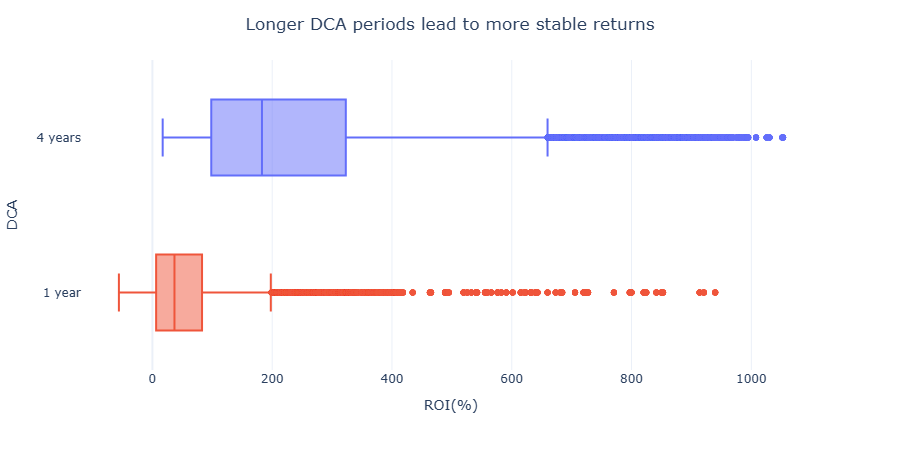

In [7]:
#  ROI(%) of both 4 years and 1 year
df_plot = pd.DataFrame({
    "ROI(%)": pd.concat([log4y["roi_percent"], log1y["roi_percent"]], ignore_index=True),
    "DCA": ["4 years"] * len(log4y) + ["1 year"] * len(log1y)
})

# box plot
fig = px.box(
    df_plot,
    y="DCA",   
    x="ROI(%)",       
    points="outliers",
    color="DCA",
    template="plotly_white",
    width=900,
    height=450
)

fig.update_layout(
    title="Longer DCA periods lead to more stable returns",
    title_x=0.5,
    showlegend=False
)

fig.show()

**First Observations**

The first thing that stands out is that Q1 of the 4-year results is higher than Q3 of the 1-year results. It’s clear that, in this case, long-term investment is more profitable than short-term investment. This can be explained by the volatility shield effect: by buying consistently, you average out high and low prices. When the price crashes, your portfolio value doesn’t drop as sharply because your average purchase price is constantly being reduced by new, cheaper buys.

Another point worth mentioning is that Q1 of the 4-year results is greater than 0, while the 1-year box contains almost 25% of data below zero.
Let’s calculate these numbers precisely.

In [8]:
# Compare means
print("4 years mean: {0}, 1 year mean: {1}".format(
log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == 1)
    ]['roi_percent'].mean()

,log1y[
        (log1y.initial_daily_invest_USD == 1) 
    ]['roi_percent'].mean()))

4 years mean: 245.32061405460385, 1 year mean: 69.19937449947312


In [9]:
neg_count = (log1y['roi_percent'] < 0).sum()
total_count = len(log1y['roi_percent'])
neg_percent = neg_count / total_count * 100

print("negative numbers of 1 year: {0}, Total 1 year numbers: {1}, negative numbers percentage: {2}%".format(neg_count,total_count,neg_percent))

negative numbers of 1 year: 5792, Total 1 year numbers: 26000, negative numbers percentage: 22.276923076923076%


**Focusing on 4-Year Results**

We have seen enough of the 1-year results. Now, let’s focus on the 4-year results.
First of all: Distribution!

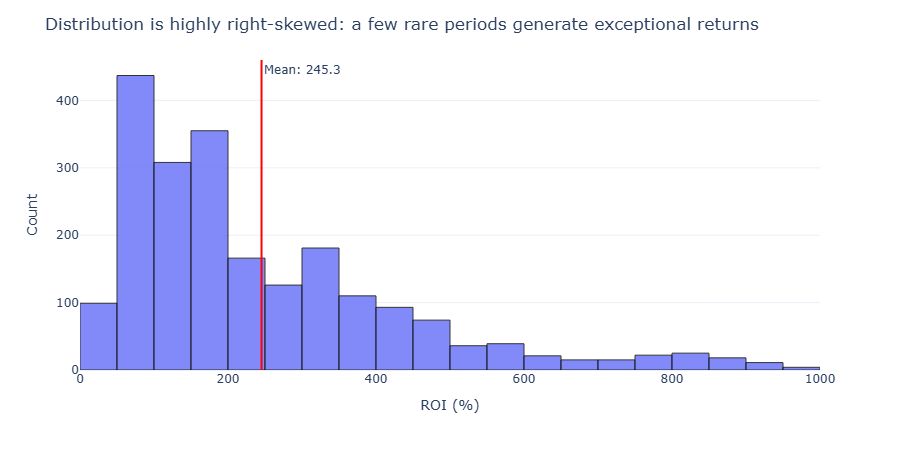

In [10]:
# just considering 1$ daily buy and constant, through 4 years
df = log4y[(log4y.initial_daily_invest_USD==1) 
    & (log4y.yearly_multiplication==1)]["roi_percent"]

# mean
mean_val = df.mean()

# at first I used KDE plot, But it was kind of confusing, so histogram is it
fig = px.histogram(
    df,
    nbins=30,              
    opacity=0.8,           
    template="plotly_white"
)


fig.update_traces(marker=dict(line=dict(width=1, color="black")))

# mean line
fig.add_vline(
    x=mean_val,
    line_width=2,
    line_color="red",
    annotation_text=f"Mean: {mean_val:.1f}",
    annotation_position="top right"
)


fig.update_layout(
    title="Distribution is highly right-skewed: a few rare periods generate exceptional returns",
    xaxis_title="ROI (%)",
    yaxis_title="Count",
    width=900,
    height=450,
    showlegend=False
)

fig.show()

**Distribution Overview**

The distribution is right-skewed, so the expected value is lower than the mean, and the majority of simulations result in a 50–200% return on investment. It is also possible to see returns above 800%, but such cases are very rare.
Let’s take a deeper look.

In [11]:
log4y[(log4y.initial_daily_invest_USD==1) & (log4y.yearly_multiplication==1)]['roi_percent'].describe()

count    2155.000000
mean      245.320614
std       190.887124
min        32.831507
25%       100.379795
50%       188.289726
75%       332.956849
max       989.590411
Name: roi_percent, dtype: float64

Q2 is 100%, which is quite impressive. So does this mean that almost 75% of simulations result in more than 100% ROI?

In [12]:
above_100_count = (log4y[(log4y.initial_daily_invest_USD==1) & (log4y.yearly_multiplication==1)]['roi_percent'] > 100).sum()
total_count = len(log4y[(log4y.initial_daily_invest_USD==1) & (log4y.yearly_multiplication==1)]['roi_percent'])
above_100_percent = above_100_count / total_count * 100

print("percentage of 4 years simulations that led to above 100% ROI: {0}%".format(above_100_percent))

percentage of 4 years simulations that led to above 100% ROI: 75.1276102088167%


**Checking Optimal Parameter Combinations**

Time to check which combination of daily_buy and multiplier performs the best.

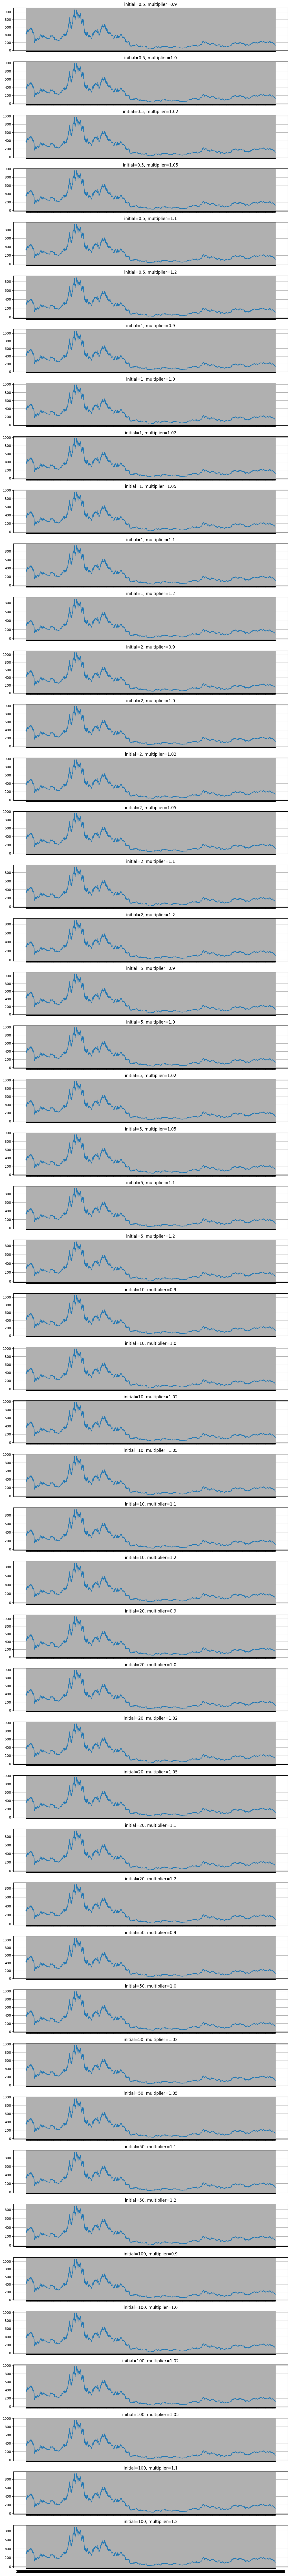

In [13]:
# generate permutations of all possible parameter combinations
total_plots = len(initial_values) * len(multipliers)

# juxtaposition, to compare them
fig, axes = plt.subplots(total_plots, 1, 
                         figsize=(12, total_plots * 2.2), 
                         sharex=True)

plot_index = 0

# I know, it's going to be a lot of (actually 48) charts, but I think it worths
for initial in initial_values:
    for mult in multipliers:

        ax = axes[plot_index]

        df_plot = log4y[
            (log4y.initial_daily_invest_USD == initial) &
            (log4y.yearly_multiplication == mult)
        ]

        ax.plot(df_plot["start_date"], df_plot["roi_percent"])
        ax.set_title(f"initial={initial}, multiplier={mult}")
        ax.grid(True)

        plot_index += 1

plt.tight_layout()
plt.show()

Hmmm, it seems I was wrong. It wasn’t worth it — they are all almost the same chart.
Let’s look at two of them (±0.1) together and compare.

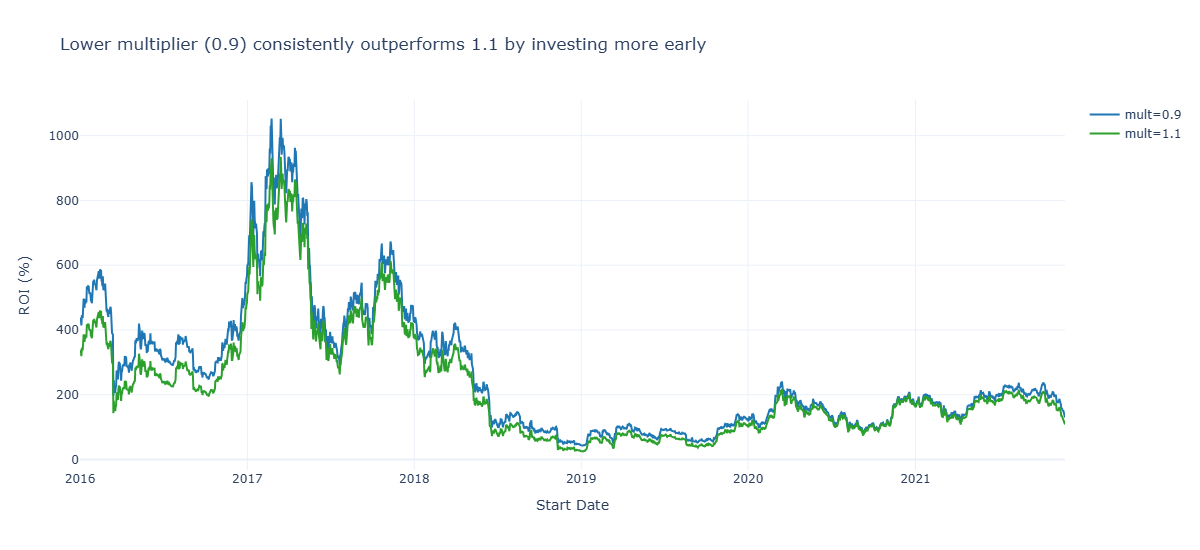

In [14]:
fig = go.Figure()

colors = {0.9: "#1f77b4", 1.1: "#2ca02c"}

# as I said 1 ± 0.1
for mult in [0.9, 1.1]:
    df_plot = log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == mult)
    ]
    # this time, superposition, because we want them on a same chart
    fig.add_trace(go.Scatter(
        x=df_plot["start_date"],
        y=df_plot["roi_percent"],
        mode="lines",
        name=f"mult={mult}",
        line=dict(width=2, color=colors[mult])
    ))

fig.update_layout(
    title="Lower multiplier (0.9) consistently outperforms 1.1 by investing more early",
    xaxis_title="Start Date",
    yaxis_title="ROI (%)",
    template="plotly_white",
    width=1200,
    height=550,
)

fig.show()

**Interpretation**

So, 0.9 outperforms. This is because BTC has increased throughout these years (as we already know), so the earlier you buy at lower prices, the higher your profit becomes. By multiplying daily_buy by 1.1, you’re actually shifting most of your investment to later periods, meaning you end up buying at higher prices.
Shall we also compare the means?

In [15]:
mean_09 = log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == 0.9)
    ]['roi_percent'].mean()

mean_11 = log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == 1.1)
    ]['roi_percent'].mean()

print("x0.9 mean: {0}, x1.1 mean: {1}".format(mean_09,mean_11))

x0.9 mean: 265.0709062054665, x1.1 mean: 227.7382775948766


Ok, so increasing the investment amount as time goes by does not lead to more profit.

**Best and Worst Days**

I would like to know which day was the best and which day was the worst in terms of ROI.

In [16]:
# constant daily 1 $
df = mean_09 = log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == 1)
    ]

# find max ROI(%)
df.loc[[df["roi_percent"].idxmax()]]

,Unnamed: 0,start_date,end_date,initial_daily_invest_USD,yearly_multiplication,final_USD,payment_USD,profit_USD,owned_BTC,roi_percent
15524,15524,2017-03-15,2021-03-13,1.0,1.0,15908.02,1460.0,14448.02,0.260083,989.590411


In [17]:
# constant daily 1$
df = mean_09 = log4y[
        (log4y.initial_daily_invest_USD == 1) &
        (log4y.yearly_multiplication == 1)
    ]

# find min ROI(%)
df.loc[[df["roi_percent"].idxmin()]]

,Unnamed: 0,start_date,end_date,initial_daily_invest_USD,yearly_multiplication,final_USD,payment_USD,profit_USD,owned_BTC,roi_percent
16182,16182,2019-01-02,2022-12-31,1.0,1.0,1939.34,1460.0,479.34,0.117336,32.831507


OK, but why? What happened on these days? What was the BTC price?

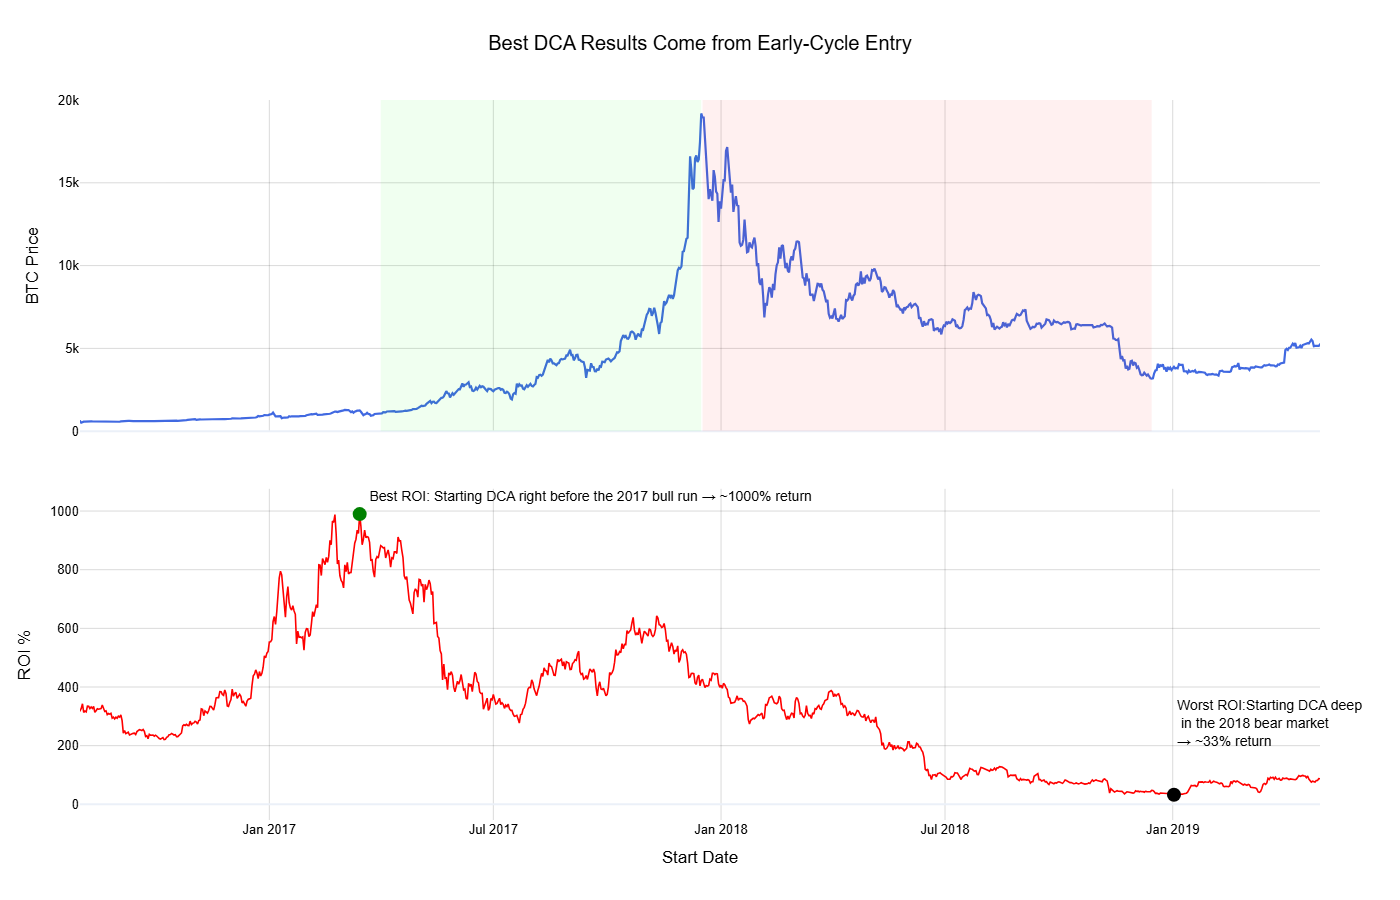

In [18]:
# BTC price history
btc = data.copy()

regimes = [
    ("2017-04-01", "2017-12-16", "rgba(0,255,0,0.06)"),   # Bull run
    ("2017-12-17", "2018-12-15", "rgba(255,0,0,0.06)")    # Bear market
]

# constant daily 1 $
roi_df = log4y[(log4y.yearly_multiplication == 1) & (log4y.initial_daily_invest_USD == 1)]
roi_df = roi_df.sort_values("start_date")

# best and worst day
best_date, best_roi = pd.to_datetime("2017-03-15"), 989.6
worst_date, worst_roi = pd.to_datetime("2019-01-02"), 32.8


# Create Subplots 
fig = make_subplots(
    rows=2,     # one for BTC price, one for ROI(%)
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08
)

# BTC Price Plot 
fig.add_trace(
    go.Scatter(
        x=data["date"],
        y=data["close"],
        mode="lines",
        line=dict(color="royalblue", width=2.2)
    ),
    row=1, col=1
)

# ROI Plot
fig.add_trace(
    go.Scatter(
        x=roi_df["start_date"],
        y=roi_df["roi_percent"],
        mode="lines",
        line=dict(color="red", width=1.6)
    ),
    row=2, col=1
)

# best ROI point
fig.add_trace(
    go.Scatter(
        x=[best_date],
        y=[best_roi],
        mode="markers+text",
        marker=dict(size=14, color="green"),
        text=["Best ROI: Starting DCA right before the 2017 bull run → ~1000% return"],
        textposition="top right",
        showlegend=False
    ),
    row=2, col=1
)

# worst ROI point
fig.add_trace(
    go.Scatter(
        x=[worst_date],
        y=[worst_roi],
        mode="markers",
        marker=dict(size=14, color="black"),
        showlegend=False
    ),
    row=2, col=1
)
 
# annotation for worst
fig.add_annotation(
    x=worst_date,
    y=worst_roi + 150, 
    text="Worst ROI:Starting DCA deep<br> in the 2018 bear market<br>→ ~33% return",
    showarrow=False,
    font=dict(size=14, color="black"),
    xanchor="left",
    yanchor="bottom",
    align="left",
     # xshift=-60, 
    row=2, col=1
)

# Styling 
fig.update_layout(
    template="plotly_white",
    height=900,
    width=1400,
    showlegend=False,
    title="Best DCA Results Come from Early-Cycle Entry",
    title_x=0.5,
    font=dict(family="Arial", size=14, color="black"),
    title_font=dict(size=20, color="black", family="Arial"),
)

common_axis_style = dict(
    title_font=dict(size=16, family="Arial", color="black"),
    tickfont=dict(size=13, family="Arial", color="black"),
    showgrid=True,
    gridcolor="rgba(0,0,0,0.15)"
)

# apply to all x and y axes
fig.update_xaxes(**common_axis_style)
fig.update_yaxes(**common_axis_style)

# upper chart
fig.update_yaxes(title="BTC Price",range=[0,20000], row=1, col=1)
fig.update_xaxes(showticklabels=False, ticks="", showline=False, title_text="", row=1, col=1)

# lower chart
fig.update_yaxes(title="ROI %",range=[pd.to_datetime("2016-08-01"), pd.to_datetime("2019-04-30")], row=2, col=1)
fig.update_xaxes(title="Start Date",range=[pd.to_datetime("2016-08-01"), pd.to_datetime("2019-04-30")], row=2, col=1)



# --- ADD VRECTS LAST (after all layout updates) ---
for s, e, c in regimes:
    fig.add_vrect(
        x0=s, 
        x1=e, 
        fillcolor=c, 
        line_width=0, 
        row=1, 
        col=1
    )


fig.show()

The chart shows that starting a DCA plan early in a new cycle—before momentum picks up—delivers the largest long-term returns, including the ~1000% peak seen before the 2017 bull run.
In contrast, starting DCA late in the cycle or deep in a weak bear phase leads to much smaller gains, sometimes as low as ~33%, even over multiple years.
Overall, cycle positioning matters: small daily buys grow dramatically when entered before broad market expansion, but produce modest results when entered after major moves are already underway.

**Halving Cycles**

Speaking of cycles, we can also check the halving dates and see how ROI(%) reacts to them.

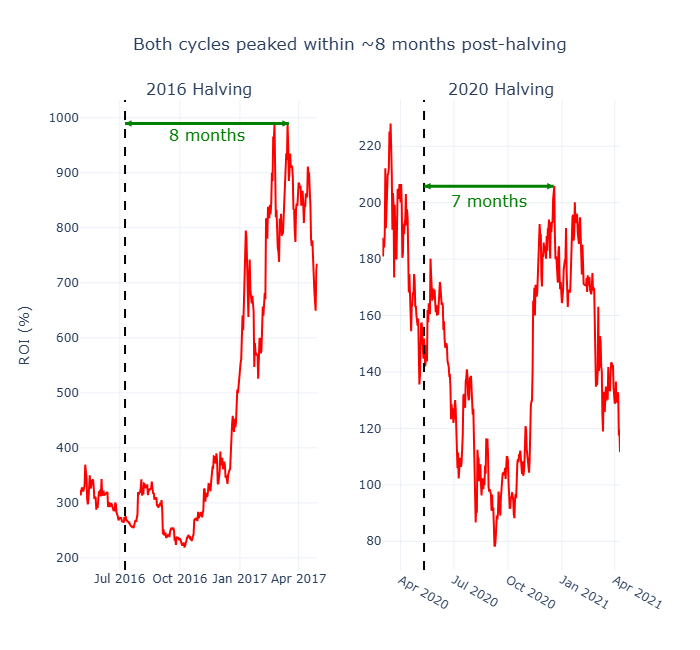

In [19]:
# constant daily 1 $
roi_df = log4y[(log4y.yearly_multiplication == 1) &
             (log4y.initial_daily_invest_USD == 1)].copy()

roi_df['start_date'] = pd.to_datetime(roi_df['start_date'])

# 2 deiiferent halving
periods = {
    "2016": {
        "start": "2016-05-01",
        "end": "2017-04-30",
        "halving": pd.to_datetime("2016-07-09"),
        "peak_date": pd.to_datetime("2017-03-17"),
        "peak_value": 989.59,
        "months_label": "8 months"
    },
    "2020": {
        "start": "2020-03-01",
        "end": "2021-04-10",
        "halving": pd.to_datetime("2020-05-11"),
        "peak_date": pd.to_datetime("2020-12-18"),
        "peak_value": 205.8151,
        "months_label": "7 months"
    }
}

# Filter ROI for each period
roi_2016 = roi_df[(roi_df['start_date'] >= periods["2016"]["start"]) &
                  (roi_df['start_date'] <= periods["2016"]["end"])]

roi_2020 = roi_df[(roi_df['start_date'] >= periods["2020"]["start"]) &
                  (roi_df['start_date'] <= periods["2020"]["end"])]


# create subplots
fig = make_subplots(
    rows=1, cols=2,
    horizontal_spacing=0.12,
    subplot_titles=("2016 Halving", "2020 Halving"),
)

def add_panel(fig, roi, period, row, col):

    # ROI Line
    fig.add_trace(
        go.Scatter(
            x=roi['start_date'],
            y=roi['roi_percent'],
            mode="lines",
            line=dict(color="red")
        ),
        row=row, col=col
    )

    # Halving Vertical Line
    fig.add_vline(
        x=period["halving"],
        line_width=2, line_dash="dash", line_color="black",
        row=row, col=col
    )


add_panel(fig, roi_2016, periods["2016"], row=1, col=1)
add_panel(fig, roi_2020, periods["2020"], row=1, col=2)


# arrows

# left chart
x1_left = periods["2016"]["halving"]
x2_left = periods["2016"]["peak_date"]
y_left = periods["2016"]["peak_value"]

# line
fig.add_shape(
    type="line",
    x0=x1_left, y0=y_left,
    x1=x2_left, y1=y_left,
    line=dict(color="green", width=3),
    row=1, col=1
)

# left arrow
fig.add_annotation(
    x=x1_left, y=y_left,
    ax=x2_left, ay=y_left,
    xref="x1", yref="y1",
    axref="x1", ayref="y1",
    showarrow=True,
    arrowhead=2, arrowsize=1.3,
    arrowcolor="green",
    row=1, col=1
)

# right arrow
fig.add_annotation(
    x=x2_left, y=y_left,
    ax=x1_left, ay=y_left,
    xref="x1", yref="y1",
    axref="x1", ayref="y1",
    showarrow=True,
    arrowhead=2, arrowsize=1.3,
    arrowcolor="green",
    row=1, col=1
)

# label under arrow
fig.add_annotation(
    x=(x1_left + (x2_left - x1_left) / 2),
    y=y_left - 20,
    text=periods["2016"]["months_label"],
    font=dict(size=16, color="green"),
    showarrow=False,
    row=1, col=1
)



# right chart
x1_right = periods["2020"]["halving"]
x2_right = periods["2020"]["peak_date"]
y_right = periods["2020"]["peak_value"]

# line
fig.add_shape(
    type="line",
    x0=x1_right, y0=y_right,
    x1=x2_right, y1=y_right,
    line=dict(color="green", width=3),
    row=1, col=2
)

# left arrow
fig.add_annotation(
    x=x1_right, y=y_right,
    ax=x2_right, ay=y_right,
    xref="x2", yref="y2",
    axref="x2", ayref="y2",
    showarrow=True,
    arrowhead=2, arrowsize=1.3,
    arrowcolor="green",
    row=1, col=2
)

# right arrow
fig.add_annotation(
    x=x2_right, y=y_right,
    ax=x1_right, ay=y_right,
    xref="x2", yref="y2",
    axref="x2", ayref="y2",
    showarrow=True,
    arrowhead=2, arrowsize=1.3,
    arrowcolor="green",
    row=1, col=2
)

# label under arrow
fig.add_annotation(
    x=(x1_right + (x2_right - x1_right) / 2),
    y=y_right - 5,
    text=periods["2020"]["months_label"],
    font=dict(size=16, color="green"),
    showarrow=False,
    row=1, col=2
)


# layout
fig.update_layout(
    title="Both cycles peaked within ~8 months post-halving",
    title_x=0.5,
    template="plotly_white",
    height=650,
    showlegend=False
)

fig.update_yaxes(title="ROI (%)", row=1, col=1)

fig.show()

**WARNING**: The Y-scales on the left and right are not the same. This is intentional, because here time matters, not percentage.

Both the 2016 and 2020 cycles reached their DCA return peaks roughly 7–8 months after the halving, showing that most of the gains happened early in the post-halving expansion.
This suggests a consistent pattern: starting DCA right after a halving captures the strongest part of the cycle, while waiting longer leads to noticeably smaller returns.

Where is the 2024 halving?
Well, we're analyzing 4-year DCA, so the latest start date available is 2021-11-24.

**Changing the Daily Investment**

One thing is still left: what happens if we change the daily_invest amount?
For example, what if we invest 10 USD per day instead of 1 USD?

In [20]:
# Q3 - Q1
def calc_iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

df = mean_09 = log4y[
        (log4y.yearly_multiplication == 1)
    ]

iqr_1  = calc_iqr(df[df.initial_daily_invest_USD==1]["profit_USD"])
iqr_10  = calc_iqr(df[df.initial_daily_invest_USD==10]["profit_USD"])

print("IQR of 1$ per day:{0}, IQR of 10$ per day:{1}%".format(iqr_1,iqr_10))

IQR of 1$ per day:3395.625, IQR of 10$ per day:33956.28%


As we can see, the IQR of 10 USD is exactly 10 times the IQR of 1 USD.
So, there’s no “best” or “worst” in this case — the more, the merrier!